# SAM 40 dataset

**Dataset:** [SAM 40: Dataset](
https://figshare.com/articles/dataset/SAM_40_Dataset_of_40_Subject_EEG_Recordings_to_Monitor_the_Induced-Stress_while_performing_Stroop_Color-Word_Test_Arithmetic_Task_and_Mirror_Image_Recognition_Task/14562090?file=27956376)

**Article:** [SAM 40: Dataset of 40 subject EEG recordings to monitor the induced-stress while performing Stroop color-word test, arithmetic task, and mirror image recognition task](https://www.sciencedirect.com/science/article/pii/S2352340921010465?ref=pdf_download&fr=RR-2&rr=96adf844ce23e918)


# Import libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
plt.ion()


import mne
mne.set_log_level('error')


import os
import random
import shutil

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.options.display.max_columns = None # показываем все колонки

# SAM40: full

In [2]:
file_path = r'epochs\sam40_full_epochs.zip'

shutil.unpack_archive(file_path, extract_dir=os.path.dirname(file_path), format="zip")
fif_path = os.path.splitext(file_path)[0] + ".fif"
sam40_full_epochs = mne.read_epochs(fif_path, preload=True)
os.remove(fif_path)

sam40_full_epochs

<EpochsFIF | 46080 events (all good), 0 – 1 s (baseline off), ~544.2 MiB, data loaded, with metadata,
 'low attention': 11520
 'high attention': 34560>

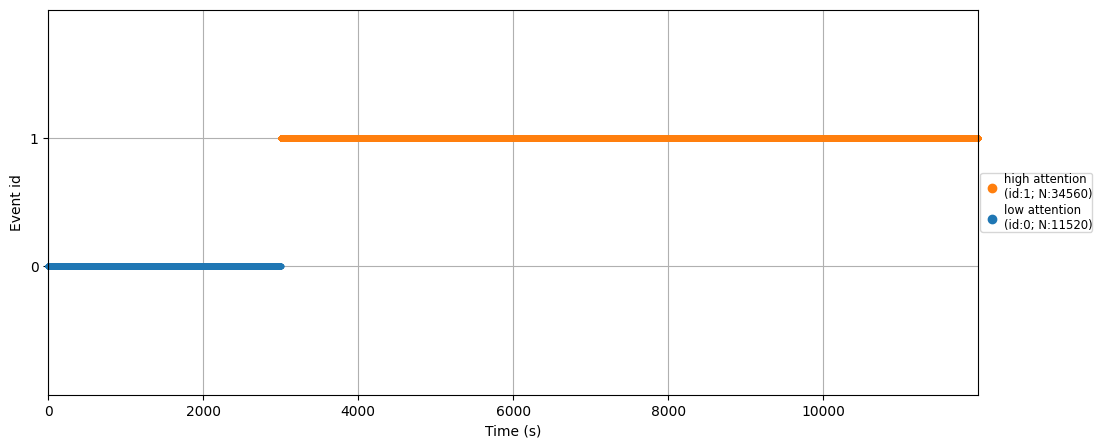

In [3]:

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    sam40_full_epochs.events,
    sam40_full_epochs.info["sfreq"],
    event_id=sam40_full_epochs.event_id,
    axes=ax
)
plt.show()

In [4]:
X = sam40_full_epochs.get_data(copy=False) 
y = sam40_full_epochs.events[:, 2]       

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")

X исходная: (46080, 12, 129) (эпохи, каналы, время)
X после reshape: (46080, 1548) (эпохи, признаки)
y: (46080,) (метки классов)


In [5]:
session_groups = sam40_full_epochs.metadata["session"].values
subject_groups = sam40_full_epochs.metadata["subject"].values

print(f"subject_groups: {subject_groups.shape} ")
print(f"session_groups: {session_groups.shape} ")

subject_groups: (46080,) 
session_groups: (46080,) 


## Baseline - Full

In [6]:
from sklearn.model_selection import StratifiedKFold,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)


metrics_table

,accuracy,precision,recall,f1
0,0.83,0.83,0.97,0.9
1,0.83,0.83,0.97,0.9
2,0.83,0.84,0.97,0.9
3,0.83,0.83,0.97,0.9
4,0.83,0.83,0.97,0.9
mean,0.83,0.83,0.97,0.9


## Cross-subject

In [7]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)

# --- 3. Классификатор ---
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.2,
    max_depth=7,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

# --- 4. CV ---
logo = LeaveOneGroupOut()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=logo.split(X, y, groups=subject_groups),
    scoring=scoring,
    return_train_score=False
)

# --- 5. Результаты ---
metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)

metrics_table

,accuracy,precision,recall,f1
0,0.77,0.77,0.99,0.87
1,0.77,0.77,1.00,0.87
2,0.62,0.73,0.78,0.75
3,0.74,0.76,0.97,0.85
4,0.73,0.75,0.97,0.85
5,0.62,0.81,0.64,0.72
6,0.66,0.74,0.83,0.78
7,0.62,0.76,0.71,0.74
8,0.77,0.79,0.94,0.86
9,0.64,0.74,0.80,0.77


## Cross-session

In [8]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)

# --- 3. Классификатор ---
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.2,
    max_depth=7,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

# --- 4. CV ---
logo = LeaveOneGroupOut()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=logo.split(X, y, groups=session_groups),
    scoring=scoring,
    return_train_score=False
)

# --- 5. Результаты ---
metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)

metrics_table

,accuracy,precision,recall,f1
0,0.73,0.78,0.88,0.83
1,0.72,0.76,0.92,0.83
2,0.73,0.77,0.90,0.83
mean,0.73,0.77,0.90,0.83


# SAM40: Stroop only


In [9]:
file_path = r'epochs\sam40_stroop_epochs.zip'

shutil.unpack_archive(file_path, extract_dir=os.path.dirname(file_path), format="zip")
fif_path = os.path.splitext(file_path)[0] + ".fif"
sam40_stroop_epochs = mne.read_epochs(fif_path, preload=True)
os.remove(fif_path)

sam40_stroop_epochs

<EpochsFIF | 23040 events (all good), 0 – 1 s (baseline off), ~272.1 MiB, data loaded, with metadata,
 'low attention': 11520
 'high attention': 11520>

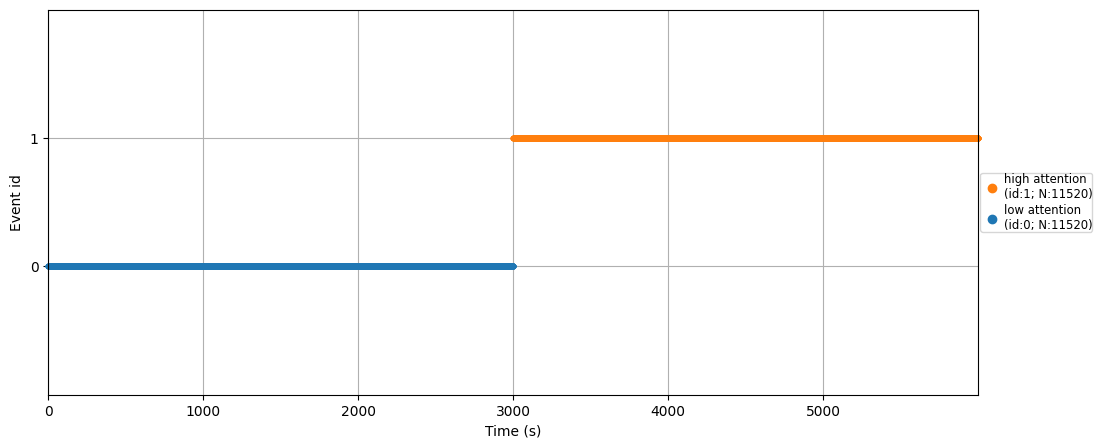

In [10]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    sam40_stroop_epochs.events,
    sam40_stroop_epochs.info["sfreq"],
    event_id=sam40_stroop_epochs.event_id,
    axes=ax
)
plt.show()

In [11]:
X = sam40_stroop_epochs.get_data(copy=False) 
y = sam40_stroop_epochs.events[:, 2]       

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")

X исходная: (23040, 12, 129) (эпохи, каналы, время)
X после reshape: (23040, 1548) (эпохи, признаки)
y: (23040,) (метки классов)


## Baseline - Stroop only

In [12]:
from sklearn.model_selection import StratifiedKFold,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)


metrics_table

,accuracy,precision,recall,f1
0,0.81,0.79,0.84,0.82
1,0.81,0.79,0.83,0.81
2,0.82,0.81,0.84,0.82
3,0.81,0.80,0.84,0.82
4,0.81,0.79,0.83,0.81
mean,0.81,0.80,0.83,0.82


# SAM40: Arithmetic only


In [13]:
file_path = r'epochs\sam40_arithmetic_epochs.zip'

shutil.unpack_archive(file_path, extract_dir=os.path.dirname(file_path), format="zip")
fif_path = os.path.splitext(file_path)[0] + ".fif"
sam40_arithmetic_epochs = mne.read_epochs(fif_path, preload=True)
os.remove(fif_path)

sam40_arithmetic_epochs

<EpochsFIF | 23040 events (all good), 0 – 1 s (baseline off), ~272.1 MiB, data loaded, with metadata,
 'low attention': 11520
 'high attention': 11520>

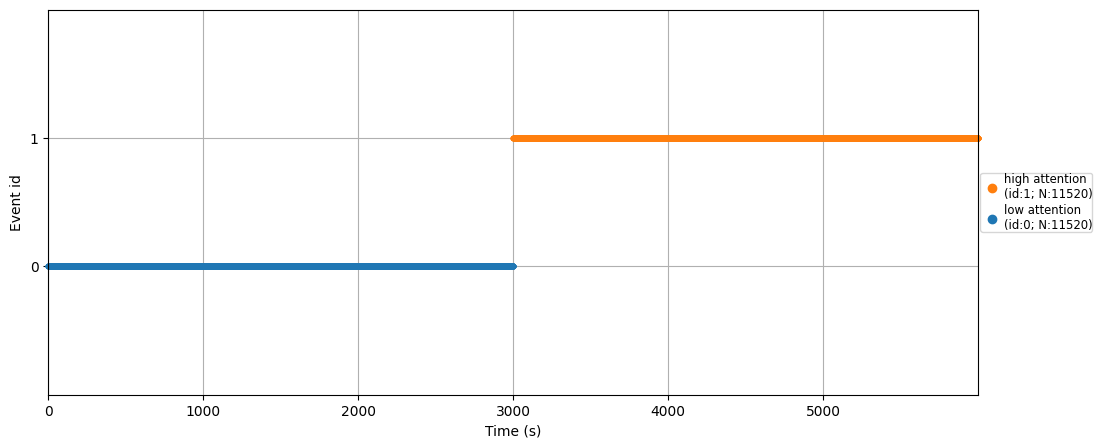

In [14]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    sam40_arithmetic_epochs.events,
    sam40_arithmetic_epochs.info["sfreq"],
    event_id=sam40_arithmetic_epochs.event_id,
    axes=ax
)
plt.show()

In [15]:
X = sam40_arithmetic_epochs.get_data(copy=False) 
y = sam40_arithmetic_epochs.events[:, 2]       

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")

X исходная: (23040, 12, 129) (эпохи, каналы, время)
X после reshape: (23040, 1548) (эпохи, признаки)
y: (23040,) (метки классов)


## Baseline - Arithmetic only

In [16]:
from sklearn.model_selection import StratifiedKFold,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)


metrics_table

,accuracy,precision,recall,f1
0,0.74,0.72,0.76,0.74
1,0.72,0.70,0.76,0.73
2,0.74,0.72,0.76,0.74
3,0.74,0.73,0.76,0.74
4,0.73,0.72,0.75,0.73
mean,0.73,0.72,0.76,0.74


# SAM40: Mirror only


In [17]:
file_path = r'epochs\sam40_mirror_epochs.zip'

shutil.unpack_archive(file_path, extract_dir=os.path.dirname(file_path), format="zip")
fif_path = os.path.splitext(file_path)[0] + ".fif"
sam40_mirror_epochs = mne.read_epochs(fif_path, preload=True)
os.remove(fif_path)

sam40_mirror_epochs

<EpochsFIF | 23040 events (all good), 0 – 1 s (baseline off), ~272.1 MiB, data loaded, with metadata,
 'low attention': 11520
 'high attention': 11520>

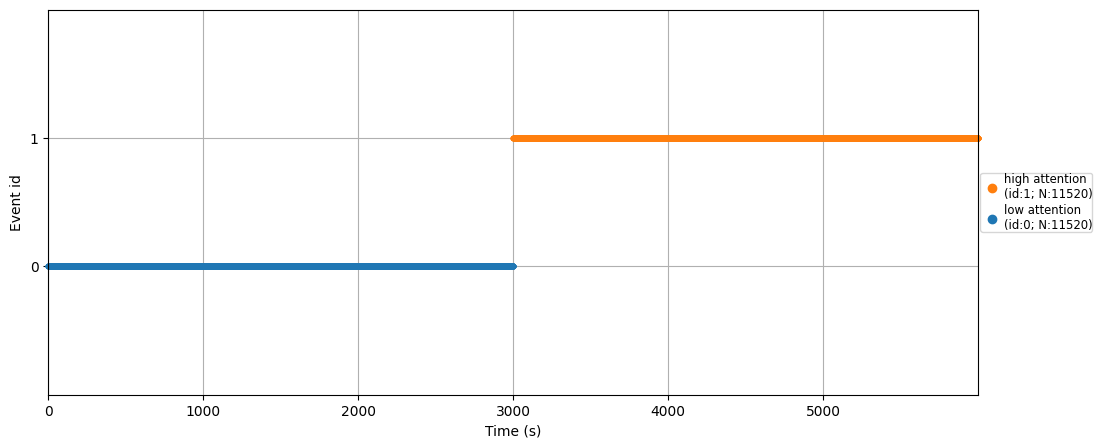

In [18]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    sam40_mirror_epochs.events,
    sam40_mirror_epochs.info["sfreq"],
    event_id=sam40_mirror_epochs.event_id,
    axes=ax
)
plt.show()

In [19]:
X = sam40_mirror_epochs.get_data(copy=False) 
y = sam40_mirror_epochs.events[:, 2]       

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")

X исходная: (23040, 12, 129) (эпохи, каналы, время)
X после reshape: (23040, 1548) (эпохи, признаки)
y: (23040,) (метки классов)


## Baseline - Mirror only

In [20]:
from sklearn.model_selection import StratifiedKFold,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)


metrics_table

,accuracy,precision,recall,f1
0,0.77,0.76,0.80,0.78
1,0.77,0.76,0.80,0.78
2,0.77,0.76,0.80,0.78
3,0.77,0.76,0.79,0.77
4,0.77,0.76,0.79,0.78
mean,0.77,0.76,0.80,0.78


# GridSearch

In [21]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# import numpy as np

# # Параметры для бинарной классификации
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'objective': ['binary:logistic'],  # бинарная классификация
#     'use_label_encoder': [False],     # чтобы избежать предупреждений
#     'eval_metric': ['logloss']        # метрика для бинарной классификации
# }

# # Создаем GridSearchCV объект
# grid_search = GridSearchCV(
#     estimator=XGBClassifier(random_state=42),
#     param_grid=param_grid,
#     scoring='accuracy',  # или другая подходящая метрика для бинарной классификации
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

In [22]:
# from sklearn.metrics import classification_report

# print("Best parameters found by GridSearchCV:")
# print(grid_search.best_params_)

# best_xgb_model = grid_search.best_estimator_

# y_pred_tuned_xgb = best_xgb_model.predict(X_test)

# print("\nTuned XGBoost Model - Classification Report:")
# print(classification_report(y_test, y_pred_tuned_xgb, target_names=['focused', 'unfocused']))

In [23]:
# Best parameters found by GridSearchCV:
# {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'objective': 'binary:logistic', 'use_label_encoder': False}

# Tuned XGBoost Model - Classification Report:
#               precision    recall  f1-score   support

#      focused       0.86      0.87      0.86      8628
#    unfocused       0.87      0.86      0.86      8640

#     accuracy                           0.86     17268
#    macro avg       0.86      0.86      0.86     17268
# weighted avg       0.86      0.86      0.86     17268